Deep Learning
=============

Assignment 6
------------

After training a skip-gram model in `5_word2vec.ipynb`, the goal of this notebook is to train a LSTM character model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import os
import numpy as np
import random
import string
import tensorflow as tf
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve

In [3]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [4]:
def read_data(filename):
  f = zipfile.ZipFile(filename)
  for name in f.namelist():
    return tf.compat.as_str(f.read(name))
  f.close()
  
text = read_data(filename)
print(text[:40])
print('Data size %d' % len(text))

 anarchism originated as a term of abuse
Data size 100000000


Create a small validation set.

In [5]:
valid_size = 1000
valid_text = text[:valid_size]
train_text = text[valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99999000 ons anarchists advocate social relations based upon voluntary as
1000  anarchism originated as a term of abuse first used against earl


Utility functions to map characters to vocabulary IDs and back.

In [6]:
vocabulary_size = len(string.ascii_lowercase) + 1 # [a-z] + ' '
first_letter = ord(string.ascii_lowercase[0])
print(vocabulary_size)

def char2id(char):
  if char in string.ascii_lowercase:
    return ord(char) - first_letter + 1
  elif char == ' ':
    return 0
  else:
    print('Unexpected character: %s' % char)
    return 0
  
def id2char(dictid):
  if dictid > 0:
    return chr(dictid + first_letter - 1)
  else:
    return ' '

print(char2id('a'), char2id('z'), char2id(' '), char2id('ï'))
print(id2char(1), id2char(26), id2char(0))

27
Unexpected character: ï
1 26 0 0
a z  


In [22]:
import numpy
from keras.utils import np_utils
class newBatchGenerator(object):

    globalIndex = 1
    first_letter = ord(string.ascii_lowercase[0])
    
    def getSeq_length(self):
        return 100
    def getBatchCount(self):
        return 1000
    
    def nextBatch1(self):
        dataX = []
        dataY = []
        seq_length = self.getSeq_length()
        batchCount = self.getBatchCount()
        if self.globalIndex*batchCount > train_size:
            self.globalIndex = 1
        batchWords = train_text[(self.globalIndex-1)*batchCount:self.globalIndex*batchCount]
        for i in range(0,len(batchWords)-seq_length,1):
            seq_in = batchWords[i:i+seq_length]
            seq_out = batchWords[i+seq_length]
            dataX.append([self.char2id(c) for c in seq_in])
            dataY.append(self.char2id(seq_out))
        n_patterns = len(dataX)
        X = numpy.reshape(dataX, (n_patterns, seq_length, 1))
        # normalize
        X = X / float(vocabulary_size)
        # one hot encode the output variable
        y = np_utils.to_categorical(dataY,nb_classes=27)
        self.globalIndex=self.globalIndex+1
        return n_patterns,X,y,dataY,dataX
    
    def char2id(self,char):
      if char in string.ascii_lowercase:
        return ord(char) - self.first_letter + 1
      elif char == ' ':
        return 0
      else:
        print('Unexpected character: %s' % char)
        return 0
  
    def id2char(self,dictid):
      if dictid > 0:
        return chr(dictid + self.first_letter - 1)
      else:
        return 
        
    
batchGenerator = newBatchGenerator()
np,XX,yy,dataY,dataX = batchGenerator.nextBatch1()
for i in range(len(dataX)):
    sql = dataX[i]
    print ("\"",''.join([id2char(value) for value in sql]), "\"")
    print("label:",id2char(dataY[i]))
    
print("================>")
np,XX,yy,dataY,dataX = batchGenerator.nextBatch1()
for i in range(len(dataX)):
    sql = dataX[i]
    print ("\"",''.join([id2char(value) for value in sql]), "\"")
    print("label:",id2char(dataY[i]))

# np,XX,yy,dataY,dataX = batchGenerator.nextBatch1()
# print ("\"",''.join([id2char(value) for value in dataX]), "\"")
# np,XX,yy,dataY,dataX = batchGenerator.nextBatch1()
# print ("\"",''.join([id2char(value) for value in dataX]), "\"")

sqlength = batchGenerator.getSeq_length()


" ons anarchists advocate social relations based upon voluntary association of autonomous individuals  "
label: m
" ns anarchists advocate social relations based upon voluntary association of autonomous individuals m "
label: u
" s anarchists advocate social relations based upon voluntary association of autonomous individuals mu "
label: t
"  anarchists advocate social relations based upon voluntary association of autonomous individuals mut "
label: u
" anarchists advocate social relations based upon voluntary association of autonomous individuals mutu "
label: a
" narchists advocate social relations based upon voluntary association of autonomous individuals mutua "
label: l
" archists advocate social relations based upon voluntary association of autonomous individuals mutual "
label:  
" rchists advocate social relations based upon voluntary association of autonomous individuals mutual  "
label: a
" chists advocate social relations based upon voluntary association of autonomous indivi

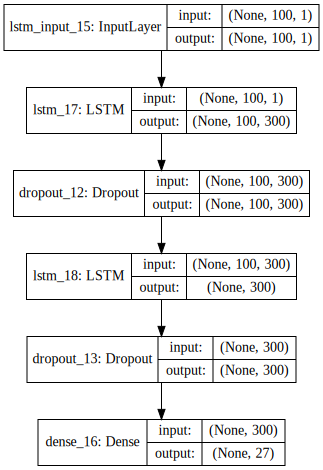

In [110]:
from keras.layers.embeddings import Embedding
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Dense, Embedding, Reshape
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.utils.visualize_util import model_to_dot, plot
from IPython.display import SVG

hidden_neurons = 300
Vsize = 27

np,XX,yy,dataY = batchGenerator.nextBatch1()

model = Sequential()
model.add(LSTM(hidden_neurons,input_shape=(sqlength,1),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(hidden_neurons))
model.add(Dropout(0.2))
model.add(Dense(27, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [111]:
for ite in range(40000):
    loss = 0.
    np,XX,yy,dataY = batchGenerator.nextBatch1() 
    loss += model.train_on_batch(XX, yy)
    if(ite%500==0):
        print(ite, loss)

0 3.26952981949
500 2.74330925941
1000 2.59372067451
1500 2.23168969154
2000 2.29152369499
2500 2.27989459038
3000 1.7335562706
3500 2.0786781311
4000 2.00535392761
4500 1.88590157032
5000 1.9637157917
5500 1.91552507877
6000 1.81144332886
6500 1.83389365673
7000 1.82182240486
7500 1.49373590946
8000 1.72209918499
8500 1.78411793709
9000 1.3767209053
9500 1.72409772873
10000 1.69286715984
10500 2.04511618614
11000 1.7598285675
11500 1.63242602348
12000 1.7733181715
12500 1.75877332687
13000 1.61299920082
13500 1.43259060383
14000 1.84915852547
14500 1.6662569046
15000 1.67244148254
15500 1.70228147507
16000 1.4262149334
16500 1.51093029976
17000 1.50446021557
17500 2.21492195129
18000 1.52470111847
18500 1.50957512856
19000 1.37460899353
19500 1.82978200912
20000 1.60969901085
20500 1.70992839336
21000 1.50207567215
21500 1.59440755844
22000 1.5992783308
22500 1.37925231457
23000 1.75166165829
23500 1.62496352196
24000 1.44815838337
24500 1.59854412079
25000 1.37497770786
25500 1.77733

In [118]:
model.save('keras_textLearn.h5')

In [12]:
from keras.models import load_model
model = load_model('keras_textLearn.h5')

Function to generate a training batch for the LSTM model.

In [14]:
# pick a random seed
import sys
np,XX,yy,dataY = batchGenerator.nextBatch1() 
start = numpy.random.randint(1, 500)

a = valid_size//sqlength
start = numpy.random.randint(1, a-1)


pattern = valid_text[(start-1)*sqlength:start*sqlength]

print([char2id(value) for value in pattern])
print ("\"",''.join([value for value in pattern]), "\"")
seedPattern = [char2id(value) for value in pattern]
print ("Seed:",len(seedPattern))
print ("\"",''.join([id2char(value) for value in seedPattern]), "\"")
#rint ("\"",''.join([chr(id2char(value)) for value in pattern]), "\"")
#rint ("\"",''.join([id2char(value) for value in pattern]), "\"")
# generate characters
for i in range(1000):
    x = numpy.reshape(seedPattern, (1, len(seedPattern), 1))
    x = x / float(27)
    prediction = model.predict(x, verbose=0)
    index = numpy.argmax(prediction)
    result = id2char(index)
    seq_in = [seedPattern]
    sys.stdout.write(result)
    seedPattern.append(index)
    seedPattern = seedPattern[1:len(seedPattern)]
    print ("\"",''.join([id2char(value) for value in seedPattern]), "\"")
print("\nDone.")

[14, 1, 18, 3, 8, 9, 19, 13, 0, 9, 19, 0, 4, 5, 18, 9, 22, 5, 4, 0, 6, 18, 15, 13, 0, 20, 8, 5, 0, 7, 18, 5, 5, 11, 0, 23, 9, 20, 8, 15, 21, 20, 0, 1, 18, 3, 8, 15, 14, 19, 0, 18, 21, 12, 5, 18, 0, 3, 8, 9, 5, 6, 0, 11, 9, 14, 7, 0, 1, 14, 1, 18, 3, 8, 9, 19, 13, 0, 1, 19, 0, 1, 0, 16, 15, 12, 9, 20, 9, 3, 1, 12, 0, 16, 8, 9, 12, 15, 19, 15]
" narchism is derived from the greek without archons ruler chief king anarchism as a political philoso "
Seed: 100
" narchism is derived from the greek without archons ruler chief king anarchism as a political philoso "
p" archism is derived from the greek without archons ruler chief king anarchism as a political philosop "
h" rchism is derived from the greek without archons ruler chief king anarchism as a political philosoph "
e" chism is derived from the greek without archons ruler chief king anarchism as a political philosophe "
r" hism is derived from the greek without archons ruler chief king anarchism as a political philosopher "
 " ism is de

KeyboardInterrupt: 